# Importação dos dados e carregamento dos pacotes

In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
df = pd.read_csv('ia_vende_normalmente.csv', delimiter= ';', index_col=[0])

# Explorações Iniciais

In [25]:
df.head()

,cliente_id,nome_cliente,data_hora_venda,valor_venda,Unnamed: 5
venda_id,,,,,
1,17012022,IA Blu Ltda,17/01/2018 09:00,"R$ 171,04",NaN
2,17012022,IA Blu Ltda,22/01/2018 12:52,"R$ 80,57",NaN
3,17012022,IA Blu Ltda,27/01/2018 18:33,"R$ 83,79",NaN
4,17012022,IA Blu Ltda,01/02/2018 17:27,"R$ 77,94",NaN
5,17012022,IA Blu Ltda,09/02/2018 08:57,"R$ 147,15",NaN


In [26]:
df.columns

Index(['cliente_id', 'nome_cliente', 'data_hora_venda', ' valor_venda ',
       'Unnamed: 5'],
      dtype='object')

Aqui notamos que a coluna valor_venda está com espaços extras, o que será um incômodo, logo vamos formatar esse nome de coluna. Notamos também uma coluna estranha ao final, contendo apenas valores nulos, a qual eliminaremos. 

In [27]:
df.rename(columns={' valor_venda ':'valor_venda'}, inplace= True)

# poderia ser feito com df.columns = [c.replace(' ', '') for c in df.columns]

In [28]:
df = df.drop('Unnamed: 5', axis = 1)

In [29]:
df.head()

,cliente_id,nome_cliente,data_hora_venda,valor_venda
venda_id,,,,
1,17012022,IA Blu Ltda,17/01/2018 09:00,"R$ 171,04"
2,17012022,IA Blu Ltda,22/01/2018 12:52,"R$ 80,57"
3,17012022,IA Blu Ltda,27/01/2018 18:33,"R$ 83,79"
4,17012022,IA Blu Ltda,01/02/2018 17:27,"R$ 77,94"
5,17012022,IA Blu Ltda,09/02/2018 08:57,"R$ 147,15"


In [30]:
df.dtypes

cliente_id          int64
nome_cliente       object
data_hora_venda    object
valor_venda        object
dtype: object

Notamos que a coluna de data não está como timestamp/datetime, portanto iremos convertê-la. 
Analogamente, a coluna valor_venda está como object/string, portanto a transformaremos em número/float.

In [31]:
# convertendo data para datetime
df['data_hora_venda'] = pd.to_datetime(df['data_hora_venda'], dayfirst=True)

In [32]:
# covertendo valor para número (float)
df.valor_venda = df.valor_venda.str.replace('R$ ','') # removendo unidade monetária
df.valor_venda = df.valor_venda.str.replace(',','.') # trocando vírgula para ponto como separador de decimal
df.valor_venda = pd.to_numeric(df.valor_venda)

In [33]:
df.dtypes

cliente_id                  int64
nome_cliente               object
data_hora_venda    datetime64[ns]
valor_venda               float64
dtype: object

In [34]:
df.nome_cliente.value_counts()

nome_cliente
IA Blu Ltda    293
Name: count, dtype: int64

In [35]:
df.cliente_id.value_counts()

cliente_id
17012022    293
Name: count, dtype: int64

Notemos que as colunas nome_cliente e cliente_id possuem apenas um único valor, portanto não são informativas e as eliminaremos da análise

In [36]:
df = df.drop(['nome_cliente', 'cliente_id'], axis = 1)

In [37]:
df.head()

,data_hora_venda,valor_venda
venda_id,,
1,2018-01-17 09:00:00,171.04
2,2018-01-22 12:52:00,80.57
3,2018-01-27 18:33:00,83.79
4,2018-02-01 17:27:00,77.94
5,2018-02-09 08:57:00,147.15


# Perguntas

## Estime a probabilidade deste cliente ficar 29 dias consecutivos sem vender. Justifique o procedimento escolhido para realizar a estimativa.

Precisamos saber como é a distribuição dos dias entre as vendas

In [38]:
df['dias_sem_vender'] = df.data_hora_venda.diff().dt.days

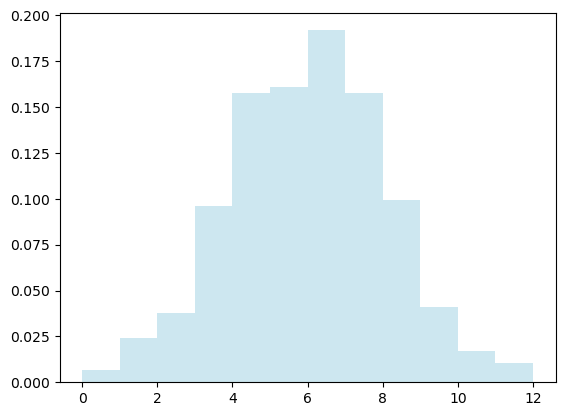

In [39]:
plt.hist(df['dias_sem_vender'], bins=range(0, 13), density=True, alpha=0.6, color='lightblue');

Como a quantidade de dias entre as vendas é uma contagem, vamos estimar uma distribuição de Poisson com os dados dessa diferença

In [40]:
diffs = df.dias_sem_vender.dropna()

# o parâmetro lambda da exponencial será utilizado como a média dos dias entre vendas
lambda_poisson = np.mean(diffs)

# usar esse parâmetro é uma boa escolha pois ele é o Estimador de Máxima Verossimilhança (EMV) da Poisson

lambda_poisson

5.523972602739726

In [41]:
np.var(diffs)

# Notemos aqui um problema teórico. A variância não é igual à média, o que deve ocorrer na distribuição de Poisson. 
# Uma opção seria utilizar no R o pacote gammacount que contém a função rgnzp (r generalized poisson), que aceita subdispersão. 

4.331617095139811

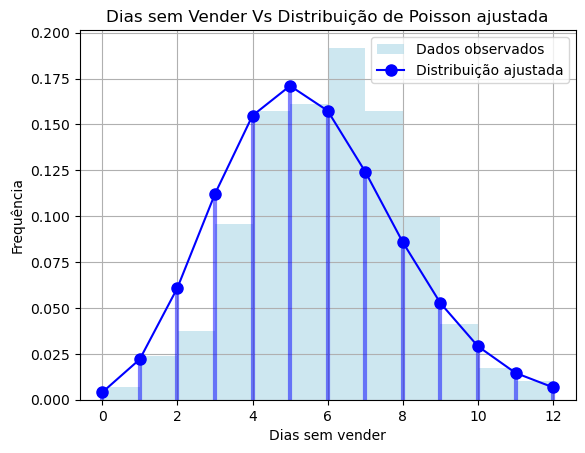

In [44]:
plt.hist(df['dias_sem_vender'], bins=range(0, 13), density=True, alpha=0.6, color='lightblue', label='Dados observados')

plt.plot(np.arange(0, 13), poisson.pmf(np.arange(0, 13), lambda_poisson), 'bo-', ms=8, label='Distribuição ajustada')
plt.vlines(np.arange(0, 13), 0, poisson.pmf(np.arange(0, 13), lambda_poisson), colors='b', lw=3, alpha=0.5)
plt.xlabel('Dias sem vender')
plt.ylabel('Frequência')
plt.legend()
plt.title('Dias sem Vender Vs Distribuição de Poisson ajustada')

# Mostrar o gráfico
plt.grid(True)
plt.show()

In [45]:
for i in [0,10,20]:
    print(f'A probabilidade estimada desse cliente ficar {i+9} dias sem vender é de {1-poisson.cdf(i+9, lambda_poisson)}')

A probabilidade estimada desse cliente ficar 9 dias sem vender é de 0.05503032555501264
A probabilidade estimada desse cliente ficar 19 dias sem vender é de 1.549136623757441e-06
A probabilidade estimada desse cliente ficar 29 dias sem vender é de 3.383959779057477e-13


Portando concluímos que, se esse cliente mantiver o padrão de vendas atual, a probabilidade de de ficar 29 dias sem vender é praticamente nula.

In [46]:
# notemos que o máximo que o cliente ficou sem vender foi 11 dias, e a probabilidade de isso ocorrer é por volta de 1.1%

1-poisson.cdf(11, lambda_poisson)

0.011334184167144934

## A partir de quantos dias consecutivos sem vendas seria plausível afirmar que o cliente deu churn? Justifique sua resposta.

In [47]:
diffs.value_counts()

dias_sem_vender
6.0     56
5.0     47
4.0     46
7.0     46
8.0     29
3.0     28
9.0     12
2.0     11
1.0      7
10.0     5
11.0     3
0.0      2
Name: count, dtype: int64

In [48]:
poisson.ppf( .99, lambda_poisson)

12.0

In [49]:
np.quantile(diffs, .99)

10.089999999999975

In [50]:
1-poisson.cdf(12, lambda_poisson)

0.004609832658724056

Notemos que o período máximo que o cliente ficou sem vender foi 11 dias. Além disso, analisando as distribuições estimada e empírica, temos que 99% do tempo as vendas devem ocorrem em no **máximo** 12 dias. Por fim, novamente pela distribuição estimada, temos que há menos de 0.5% de chance de demorar 13 ou mais dias. 

Logo concluímos que para esse cliente, 13 dias sem venda provavelmente implica em churn. n.

## É possível perceber uma tendência nas vendas? Justifique.

Inicialmente, vamos analisar como está o comportamento das vendas desse cliente ao longo do tempo

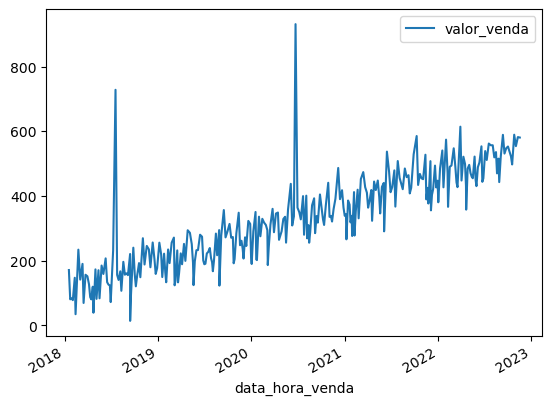

In [51]:
df.plot.line('data_hora_venda', 'valor_venda');

Notamos uma clara tendência de crescimento, porém vamos analisar de forma mais cuidadosa

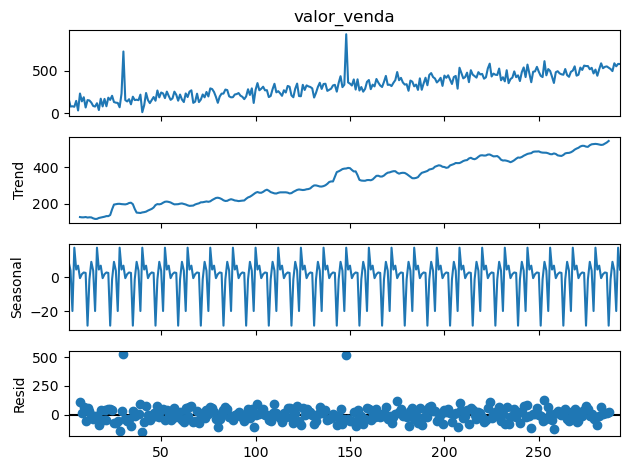

In [54]:
result = seasonal_decompose(df.valor_venda, model='additive', period=12)
result.plot()
plt.show()

Notemos que de fato há uma tendência de crescimento que não se deve apenas à oscilações dentro de um mesmo mês.

## Faça uma previsão para o volume de vendas dos próximos 15 dias do cliente. Aqui, quanto maior a expertise demonstrada em temas como: escolha do modelo, pré-processamento dos dados, estimativa de erro cometido, etc., melhor.

Não sendo constantes os tempos entre vendas, métodos como ARIMA não são os mais recomendados. Portanto usaremos uma simulação a partir da distribuição poisson estimada anteriormente para a quantidade de vendas que ocorrerão nos próximos 15 dias.

In [55]:
# Simulação para a quantia de vendas estimada em 15 dias.
dados = []

for i in range(10000):
    cont = 0
    soma = 0
    while (soma<=15):
        r = poisson.rvs(lambda_poisson, 1)
        soma += r
        cont += 1   
    dados.append(cont)

In [71]:
dados = pd.DataFrame(dados)

array([[<Axes: title={'center': '0'}>]], dtype=object)

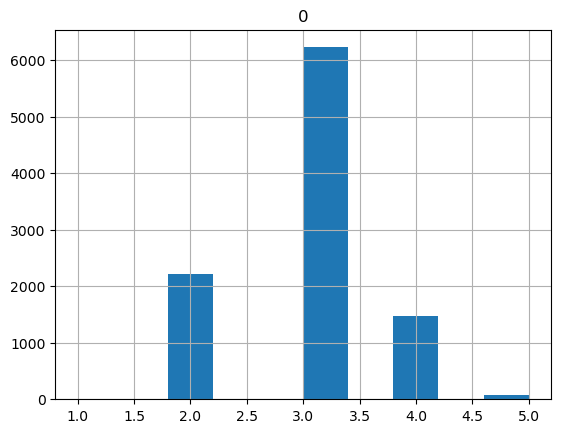

In [57]:
dados.hist()

In [102]:
np.quantile(dados, [0.01,0.25,.5,.75, 0.99])

array([2., 3., 3., 3., 4.])

In [59]:
dados.value_counts()

3    6226
2    2224
4    1468
5      77
1       5
Name: count, dtype: int64

De forma simulada, temos que, mantendo o padrão atual, ocorram entre 2 e 4 compras nos próximos 15 dias. Sendo o mais provável, 3 compras. 

In [60]:
df.tail(12)

,data_hora_venda,valor_venda,dias_sem_vender
venda_id,,,
282,2022-09-04 14:31:00,520.31,5.0
283,2022-09-13 03:43:00,588.95,8.0
284,2022-09-19 07:51:00,531.04,6.0
285,2022-09-26 02:13:00,547.56,6.0
286,2022-10-02 23:57:00,552.80,6.0
287,2022-10-09 05:04:00,537.04,6.0
288,2022-10-14 18:35:00,522.18,5.0
289,2022-10-19 07:15:00,497.42,4.0
290,2022-10-27 10:11:00,589.32,8.0


Como há uma sazonalidade mensal, utilizaremos essa informação para uma estimativa da média das vendas nos próximos 15 dias.

Tendo isso em vista e a variação não tão grande em espaços curtos de tempo, vamos modelar o gasto das vendas como uma normal de média dada pela média das últimas 12 vendas (2 meses) realizadas e variância das mesmas 12 vendas.

In [61]:
ultimas_vendas = df[-12:-1]
media = np.mean(ultimas_vendas.valor_venda)
desvio = np.std(ultimas_vendas.valor_venda)

In [65]:
normal = norm(media,desvio)

In [83]:
# Simulação para o valor acumulado em 15 dias:
somas = []
A = (dados.value_counts()[2]+dados.value_counts()[3]+dados.value_counts()[4])
for i in range(100):
    n = np.random.choice([2,3,4],p = [dados.value_counts()[2]/A, dados.value_counts()[3]/A, dados.value_counts()[4]/A])
    soma = 0
    for j in range(n):
        soma += normal.rvs()
    somas.append(soma)

# Note que a distribuição é uma mistura de variáveis aleatórias, portanto o resultado esperado é uma distribuição multimodal

In [92]:
somas = pd.DataFrame(somas)
media_boot = np.mean(somas)

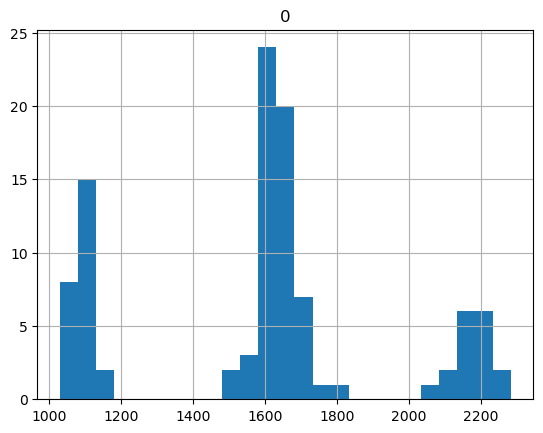

In [85]:
somas.hist(bins=25);

Utilizando apenas a distribuição boostrap, temos abaixo o intervalo de confiança de 90% para o acumulado de vendas estimado nos próximos 15 dias. 

In [88]:
np.quantile(somas,[.05,.5,.95])

array([1070.7033686 , 1622.9971063 , 2208.98563476])

In [96]:
# Erro da estimativa bootstrap
difs_boot = somas - media_boot
erro_boot = np.sqrt(np.sum(difs_boot)/(10000-1))

erro_boot

C:\Users\Eduardo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Eduardo\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0   NaN
dtype: float64